## Notebook to score cells based on gene set

attempt to use this functionality for determing scores for
- disease associated microglia (DAM) 
    - Hu Y, Fryatt GL, Ghorbani M et al. Replicative senescence dictates the emergence of disease-associated microglia and contributes to Aβ pathology. Cell Rep 2021;35:109228.
    https://www.sciencedirect.com/science/article/pii/S2211124721005799
        - "DAM signature (Cst7, Csf1, Lpl, Apoe, Spp1, Cd74, Itgax)"
- senescence
    - Hu Y, Fryatt GL, Ghorbani M et al. Replicative senescence dictates the emergence of disease-associated microglia and contributes to Aβ pathology. Cell Rep 2021;35:109228.
    https://www.sciencedirect.com/science/article/pii/S2211124721005799?via%3Dihub
        - "custom senescence signature (Cdkn2a, Cdkn1a, Cdkn2d, Casp8, Il1b, Glb1, Serpine1)"
    - Tabula Muris Consortium. A single-cell transcriptomic atlas characterizes ageing tissues in the mouse. Nature 2020;583:590–5.
    https://pubmed.ncbi.nlm.nih.gov/32669714/
        - Canonical Senescence Pathway (ATM,BMI1,CCND1,CCNE1,CDK2,CDK4,CDK6,CDKN1A,CDKN2A,CDKN2D,CHEK1,CHEK2,E2F1,E2F3,ETS1,ETS2,MDM2,RB1,RBL2,SATB1,TP53,TWIST1)
        - Senescence Responses (AKT1,CALR,CCL2,CCL20,CCL5,CCL8,CD44,COL1A1,COL3A1,CSF2,CXCL1,CXCL2,CXCL5,CXCL8,FGF2,FGF7,FN1,GLB1,ICAM,IGFBP2,IGFBP4,IGFBP7,IL11,IL1A,IL1B,IL6,LIP,LMNB1,MMP1,MMP10,MMP12,MMP3,NFIA,PLAUR,PTEN,SPARC,SERPINB2,SERPINE1,TBX2,TBX3,TGFB1I1,THBS1\xca(TSP-1),TIMP1,TIMP2,TNF,VEGFA,VEGFB,VIM)
        - Senescence Initiators (ABL1,AKT1,ALDH1A3,CCNA2,CCNB1,CDC25C,CDKN1B,CDKN1C,CDKN2B,CDKN2C,CITED2,CREG1,EGR1,GADD45A,GSK3B,HRAS,ID1,IFNG,IGF1,IGF1R,IGFBP3,IGFBP5,IGFBP7,ING1,IRF3,IRF5,IRF7,MAP2K1,,MAP2K3,MAP2K6,MAPK14,MAPK14,MORC3,MYC,NBN,NFKB1,NOX4,PCNA,PIK3CA,PLAU,PRKCD,RBL1,SIRT1,SOD1,SOD2,TERF2,TERT,TGFB1,TP53BP1)
    


In [1]:
!date

Fri Oct  7 16:24:42 EDT 2022


#### import libraries

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [36]:
# naming
project = 'aging'

# directories 
wrk_dir = f'/labshare/raph/datasets/adrd_neuro/{project}'
quants_dir = f'{wrk_dir}/demux'

# in files
in_file = f'{quants_dir}/{project}.pegasus.leiden_085.subclustered.h5ad'

# variables
DEBUG = True
dpi_value = 50
gene_sets = {'DAM': ['CST7', 'CSF1', 'LPL', 'APOE', 'SPP1', 'CD74', 'ITGAX'],
             'CSS': ['CDKN2A', 'CDKN1A', 'CDKN2D', 'CASO8', 'IL1B', 'GLB1', 'SERPINE1'],
             'CSP': ['ATM', 'BMI1', 'CCND1', 'CCNE1', 'CDK2', 'CDK4', 'CDK6', 
                     'CDKN1A', 'CDKN2A', 'CDKN2D', 'CHEK1', 'CHEK2', 'E2F1', 
                     'E2F3', 'ETS1', 'ETS2', 'MDM2', 'RB1', 'RBL2', 'SATB1', 
                     'TP53', 'TWIST1'],
             'SR': ['AKT1', 'CALR', 'CCL2', 'CCL20', 'CCL5', 'CCL8', 'CD44', 
                    'COL1A1', 'COL3A1', 'CSF2', 'CXCL1', 'CXCL2', 'CXCL5', 
                    'CXCL8', 'FGF2', 'FGF7', 'FN1', 'GLB1', 'ICAM', 'IGFBP2', 
                    'IGFBP4', 'IGFBP7', 'IL11', 'IL1A', 'IL1B', 'IL6', 'LIP',
                    'LMNB1', 'MMP1', 'MMP10', 'MMP12', 'MMP3', 'NFIA', 'PLAUR', 
                    'PTEN', 'SPARC', 'SERPINB2', 'SERPINE1', 'TBX2', 'TBX3', 
                    'TGFB1I1', 'THBS1\xca(TSP-1)', 'TIMP1', 'TIMP2', 'TNF', 
                    'VEGFA', 'VEGFB', 'VIM'],
             'SI': ['ABL1', 'AKT1', 'ALDH1A3', 'CCNA2', 'CCNB1', 'CDC25C', 
                    'CDKN1B', 'CDKN1C', 'CDKN2B', 'CDKN2C', 'CITED2', 'CREG1', 
                    'EGR1', 'GADD45A', 'GSK3B', 'HRAS', 'ID1', 'IFNG', 'IGF1', 
                    'IGF1R', 'IGFBP3', 'IGFBP5', 'IGFBP7', 'ING1', 'IRF3', 
                    'IRF5', 'IRF7', 'MAP2K1', 'MAP2K3', 'MAP2K6', 'MAPK14', 
                    'MAPK14', 'MORC3', 'MYC', 'NBN', 'NFKB1', 'NOX4', 'PCNA', 
                    'PIK3CA', 'PLAU', 'PRKCD', 'RBL1', 'SIRT1', 'SOD1', 'SOD2',
                    'TERF2', 'TERT', 'TGFB1', 'TP53BP1']}

### read the anndata (h5ad) file

In [5]:
%%time
adata = sc.read(in_file, cache=True)
print(adata)

Only considering the two last: ['.subclustered', '.h5ad'].
Only considering the two last: ['.subclustered', '.h5ad'].
AnnData object with n_obs × n_vars = 167945 × 35441
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group', 'broad_celltype'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'broad_celltype_colors', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'new_anno_colors', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_diffmap', 'X_fle',

### Plot the clusters

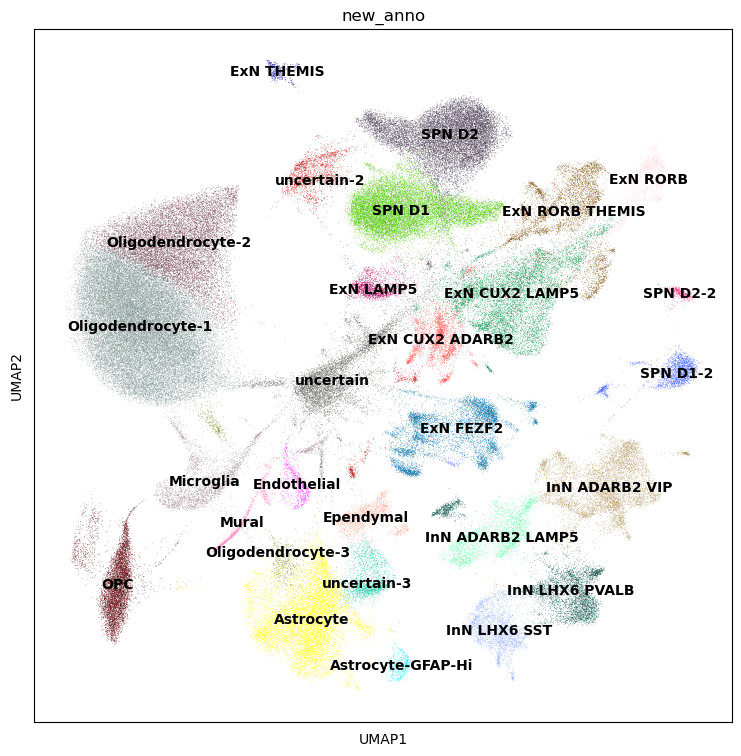

In [12]:
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    sc.pl.umap(adata, color=['new_anno'], legend_loc='on data')

### generate density plot for brain region

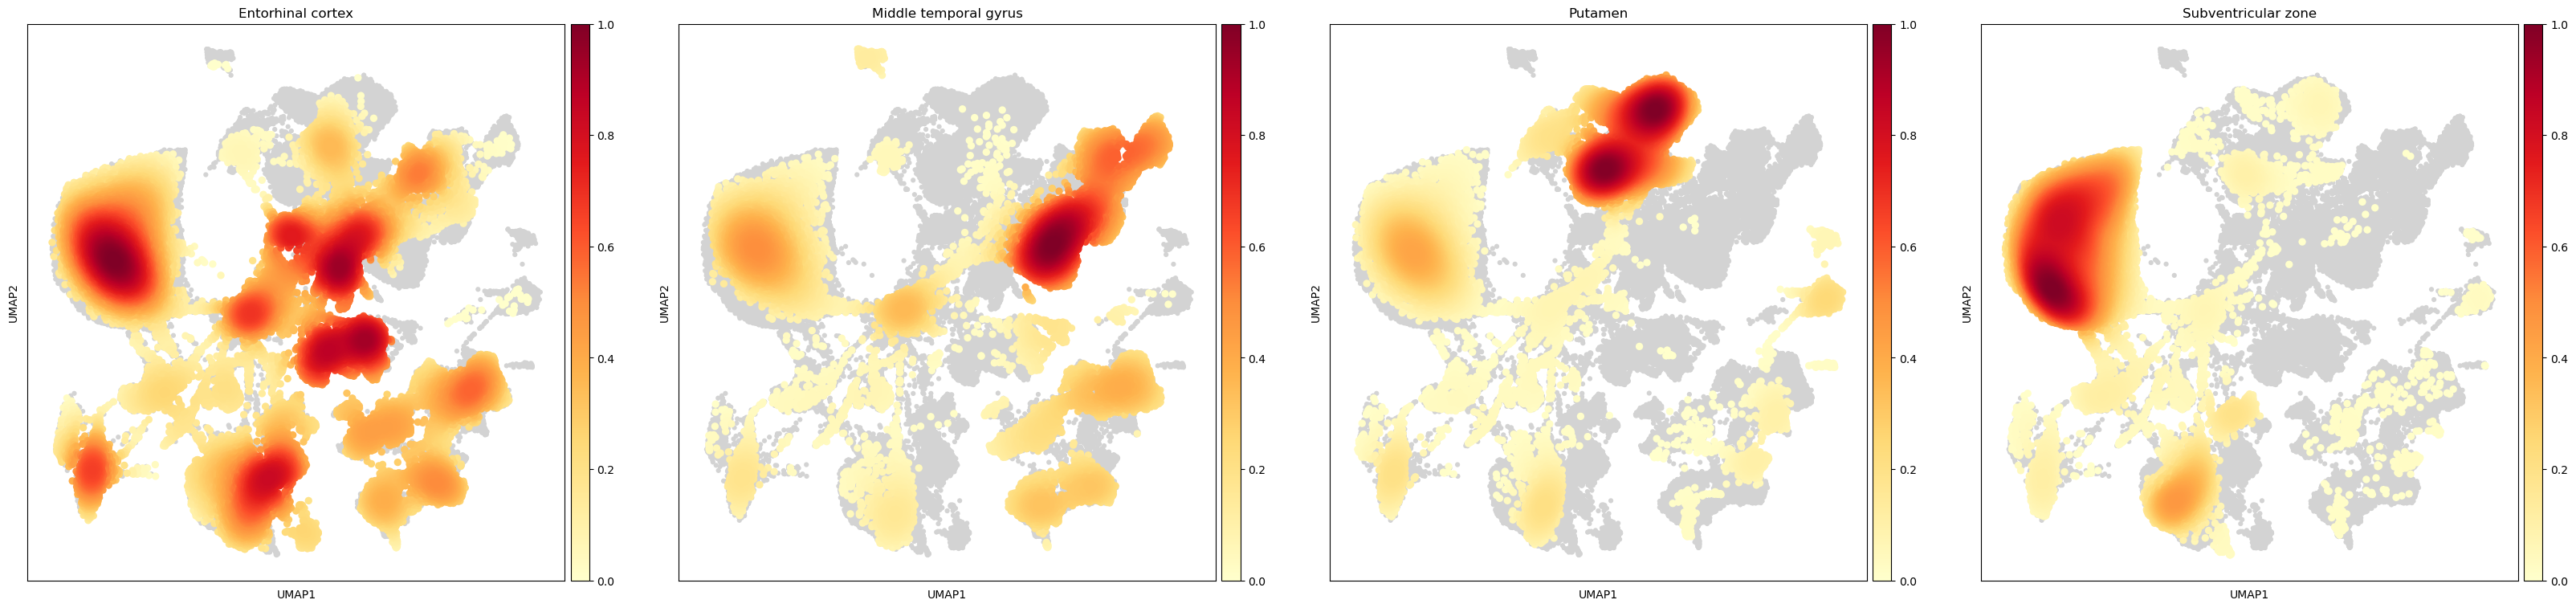

In [16]:
sc.tl.embedding_density(adata, groupby='Brain_region')
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    sc.pl.embedding_density(adata, groupby='Brain_region')

### generate density plot for age group

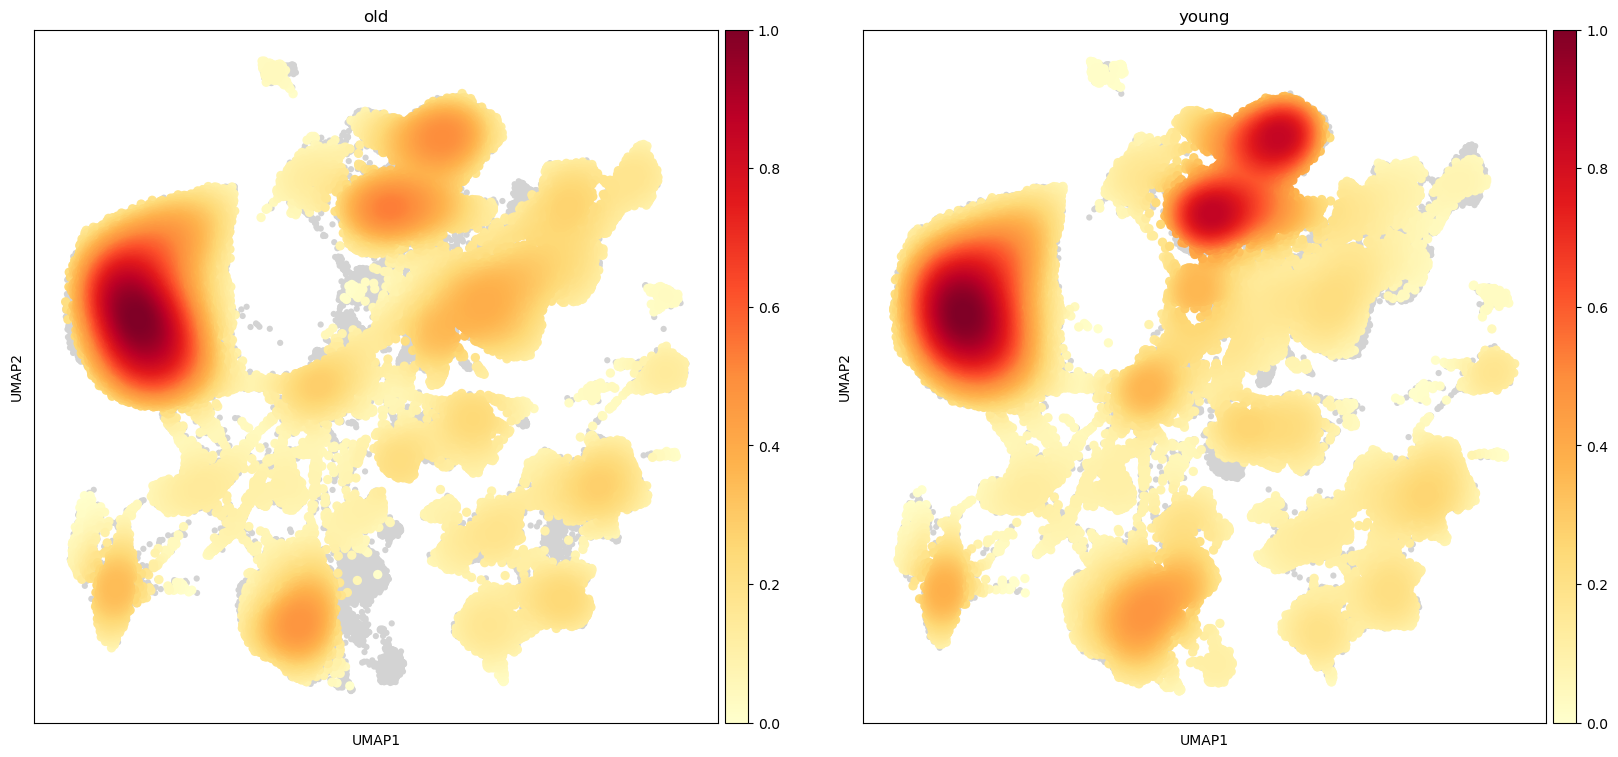

In [25]:
sc.tl.embedding_density(adata, groupby='Age_group')
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    sc.pl.embedding_density(adata, groupby='Age_group')

### score the DAM

In [50]:
%%time
sc.tl.score_genes(adata, gene_sets['DAM'], score_name='DAM_score', use_raw=True)

/home/gibbsr/anaconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


CPU times: user 6.11 s, sys: 697 ms, total: 6.81 s
Wall time: 6.81 s


<AxesSubplot:ylabel='Frequency'>

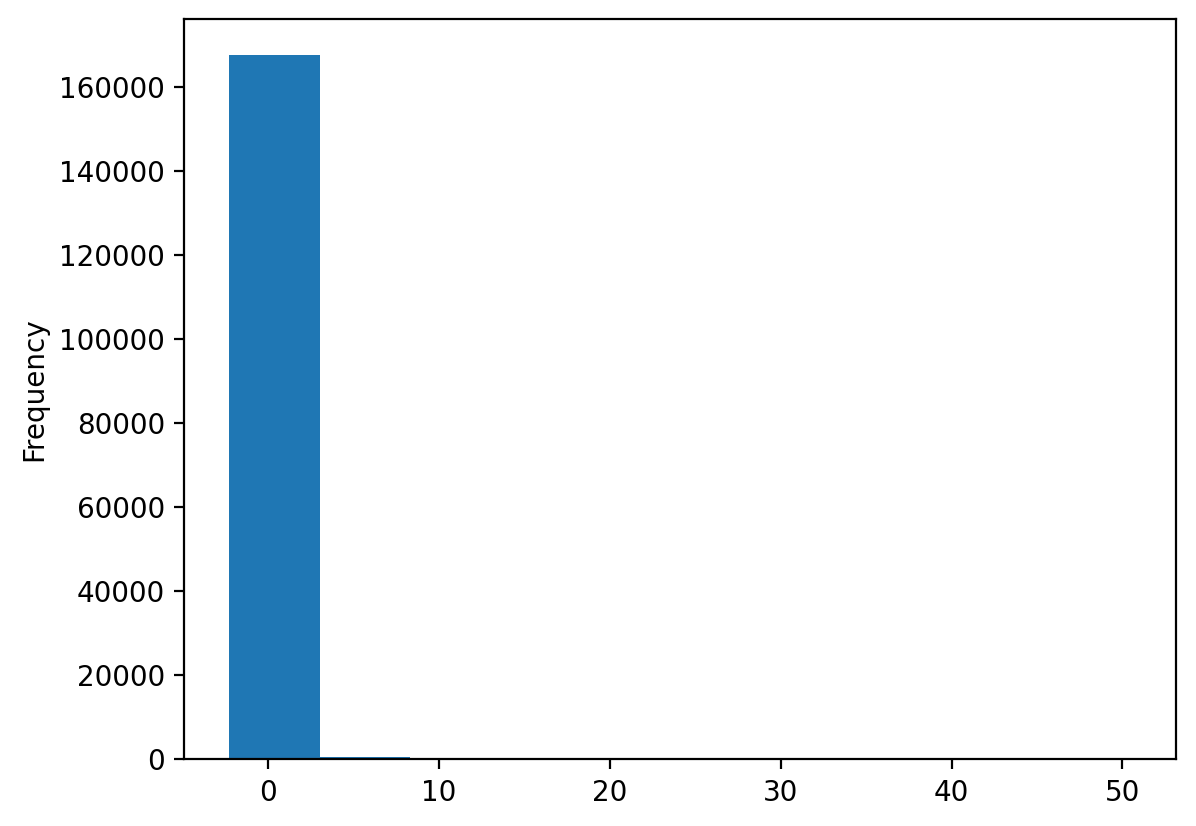

In [51]:
adata.obs.DAM_score.plot.hist()

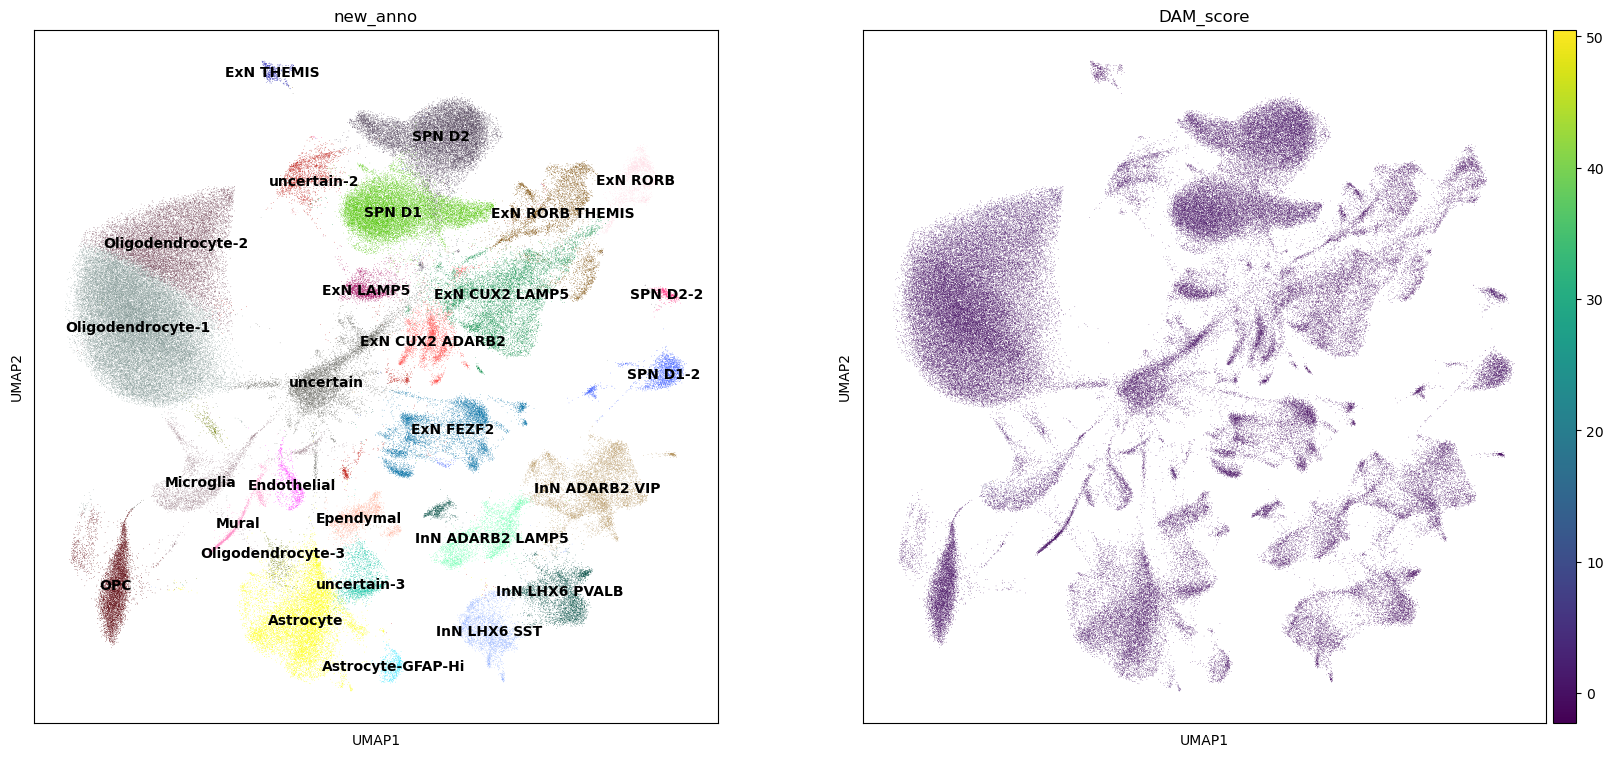

In [54]:
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    sc.pl.umap(adata, color=['new_anno', 'DAM_score'], legend_loc='on data')

### score the CSS, custom senescence signature

In [55]:
%%time
sc.tl.score_genes(adata, gene_sets['CSS'], score_name='CSS_score', use_raw=True)

/home/gibbsr/anaconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


CPU times: user 5.98 s, sys: 705 ms, total: 6.69 s
Wall time: 6.69 s


<AxesSubplot:ylabel='Frequency'>

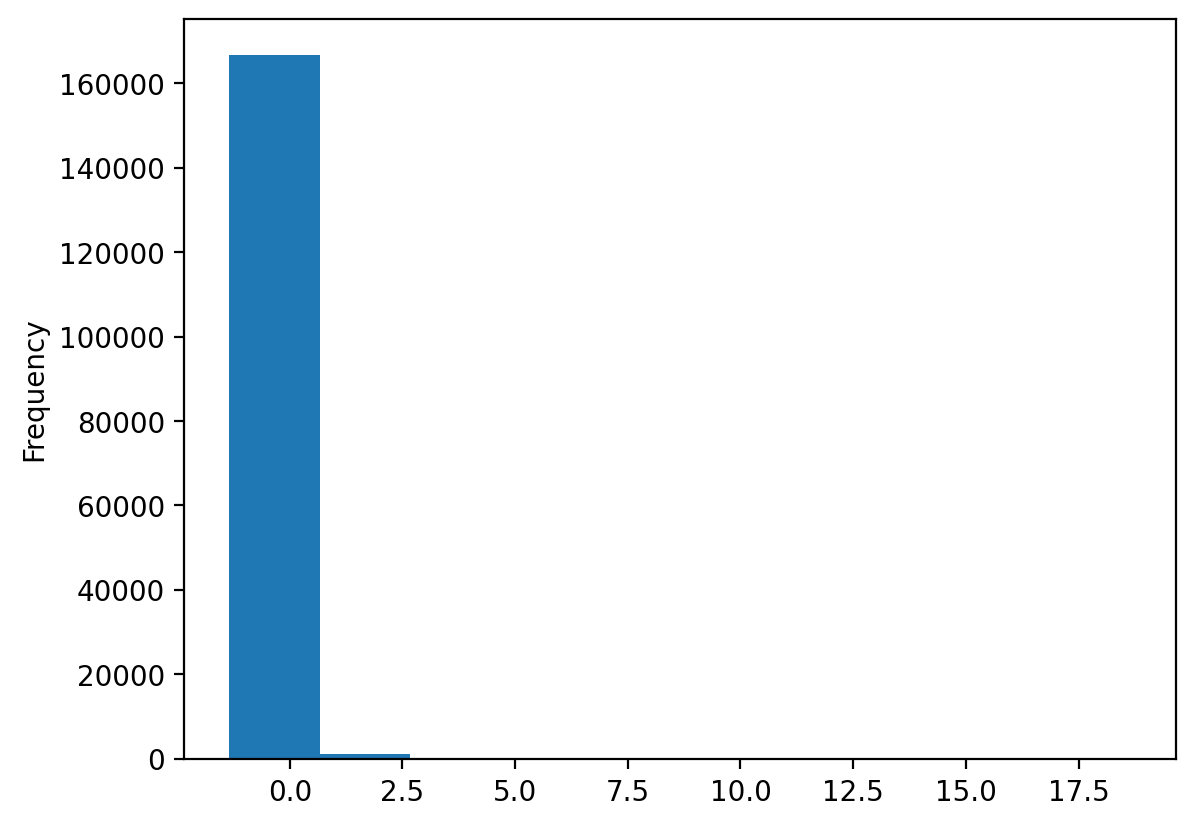

In [56]:
adata.obs.CSS_score.plot.hist()

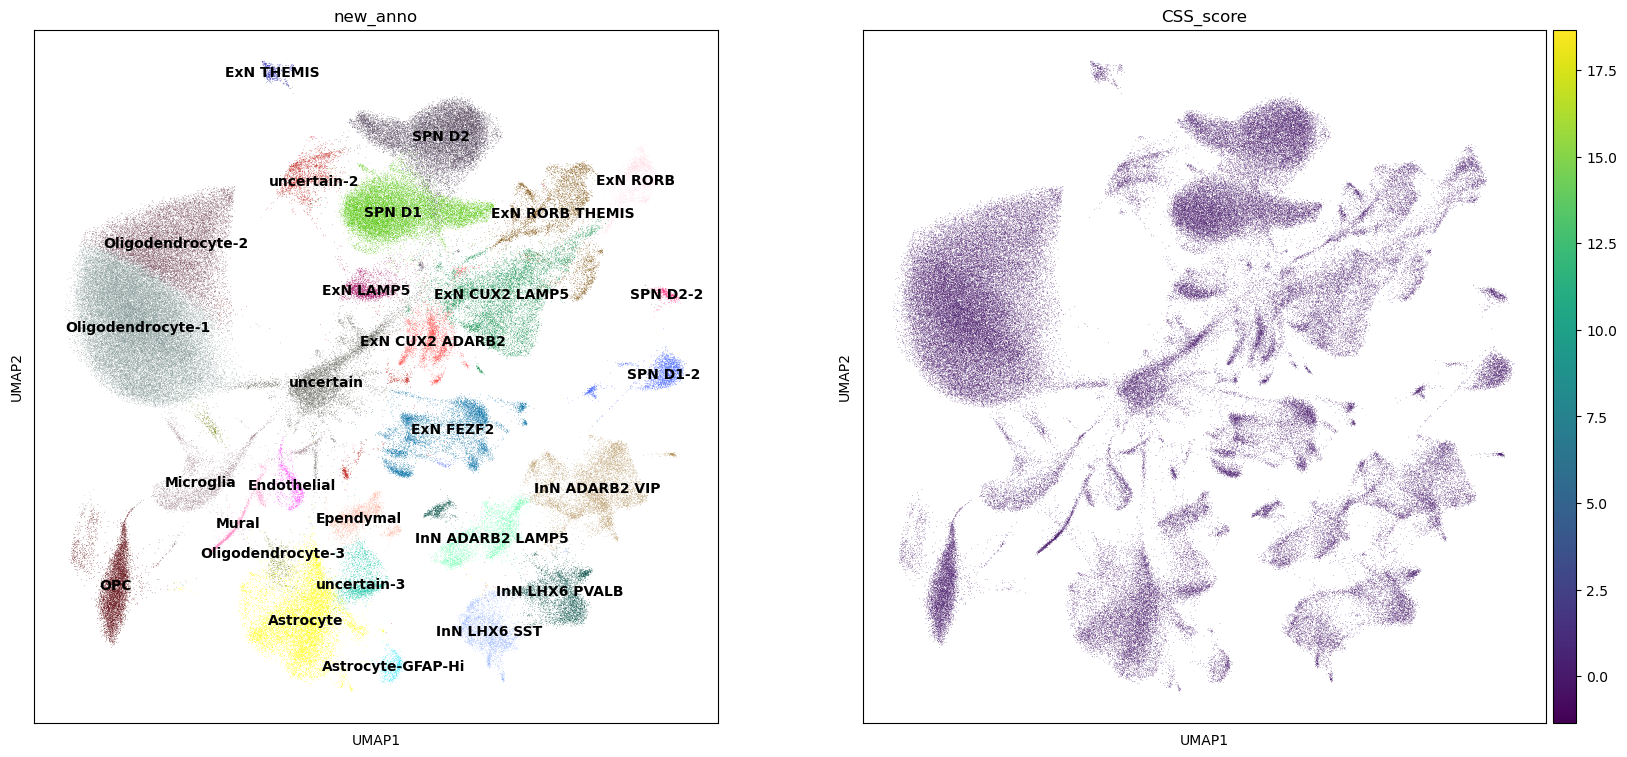

In [57]:
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    sc.pl.umap(adata, color=['new_anno', 'CSS_score'], legend_loc='on data')

### score the CSP, Canonical Senescence Pathway

In [58]:
%%time
sc.tl.score_genes(adata, gene_sets['CSP'], score_name='CSP_score', use_raw=True)

/home/gibbsr/anaconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


CPU times: user 5.88 s, sys: 757 ms, total: 6.64 s
Wall time: 6.64 s


<AxesSubplot:ylabel='Frequency'>

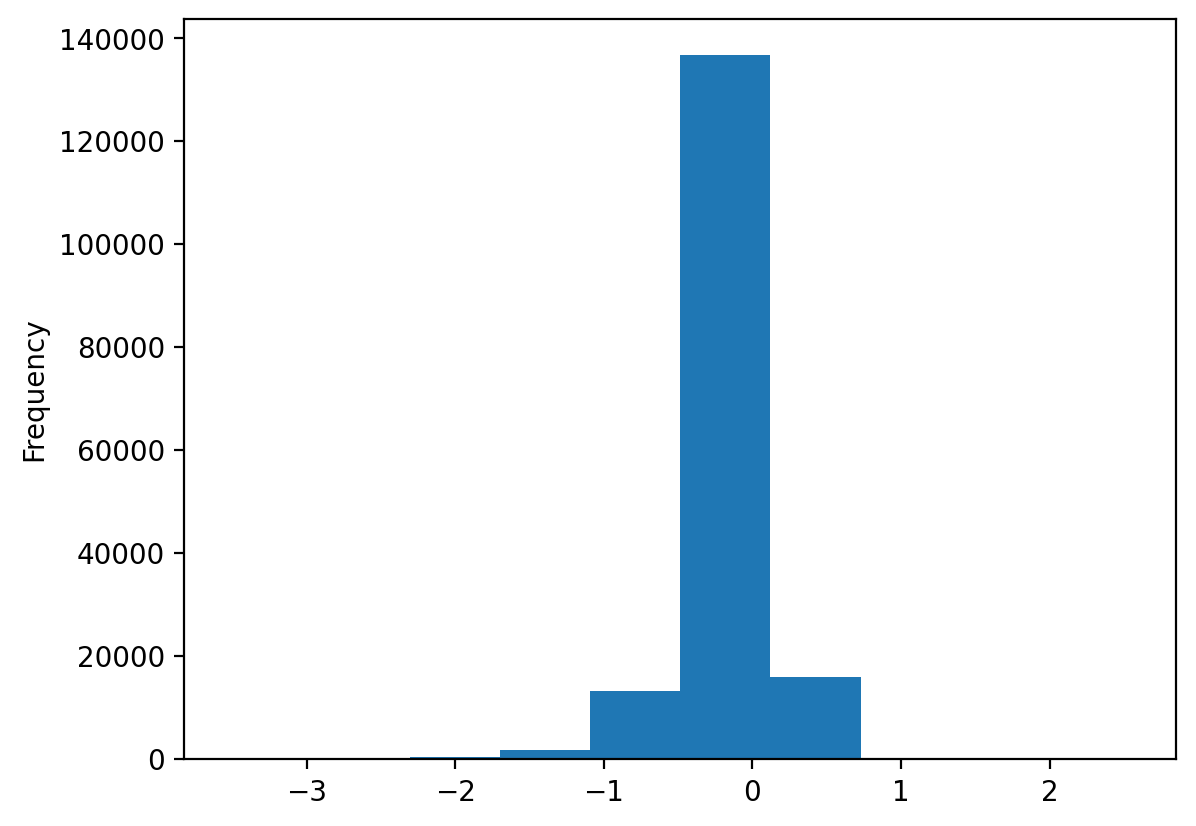

In [59]:
adata.obs.CSP_score.plot.hist()

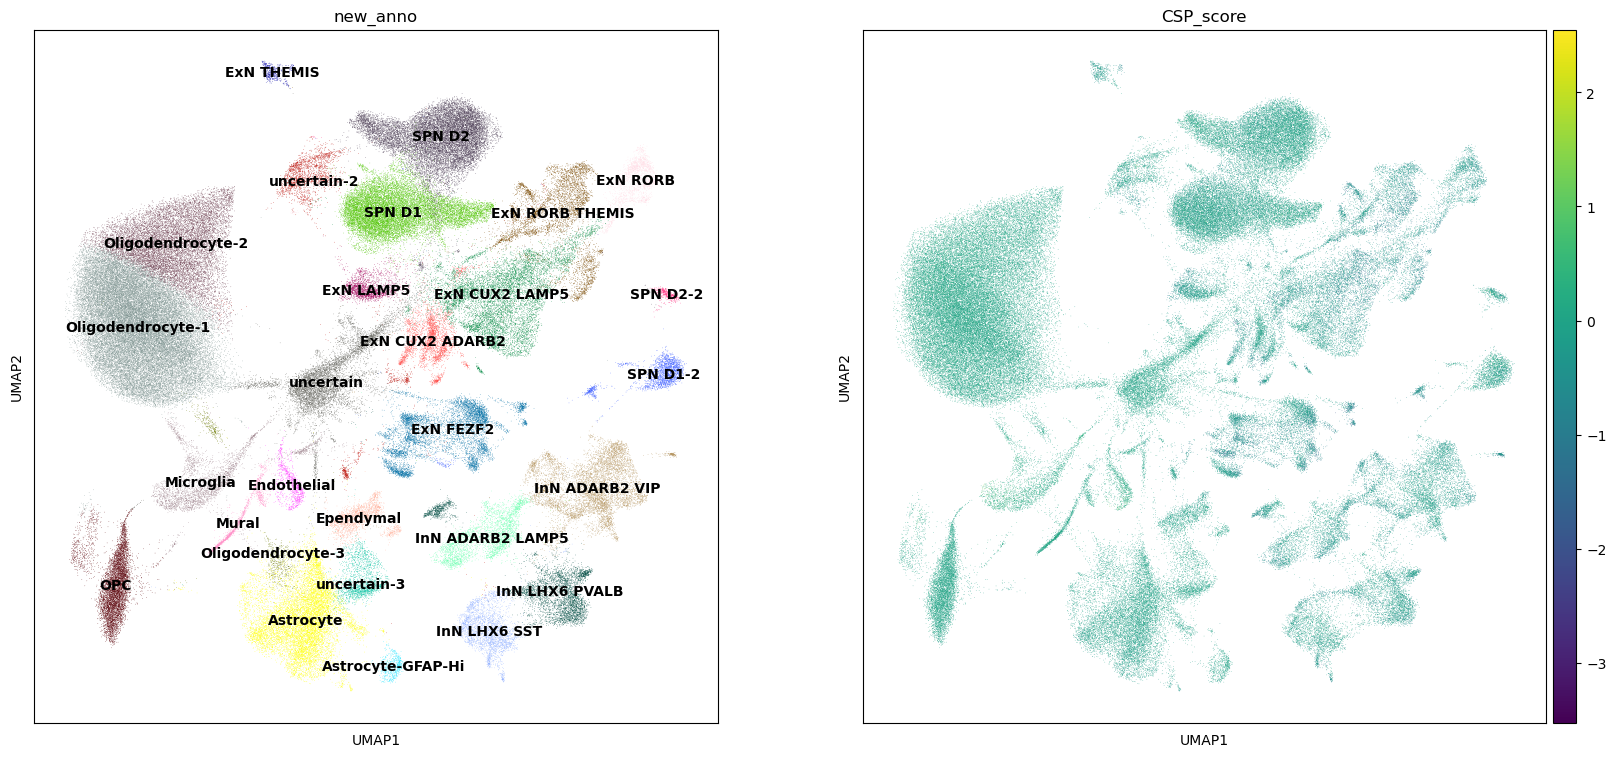

In [61]:
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    sc.pl.umap(adata, color=['new_anno', 'CSP_score'], legend_loc='on data')

### score the SR, Senescence Responses

In [63]:
%%time
sc.tl.score_genes(adata, gene_sets['SR'], score_name='SR_score', use_raw=True)

/home/gibbsr/anaconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


CPU times: user 4.75 s, sys: 692 ms, total: 5.44 s
Wall time: 5.44 s


<AxesSubplot:ylabel='Frequency'>

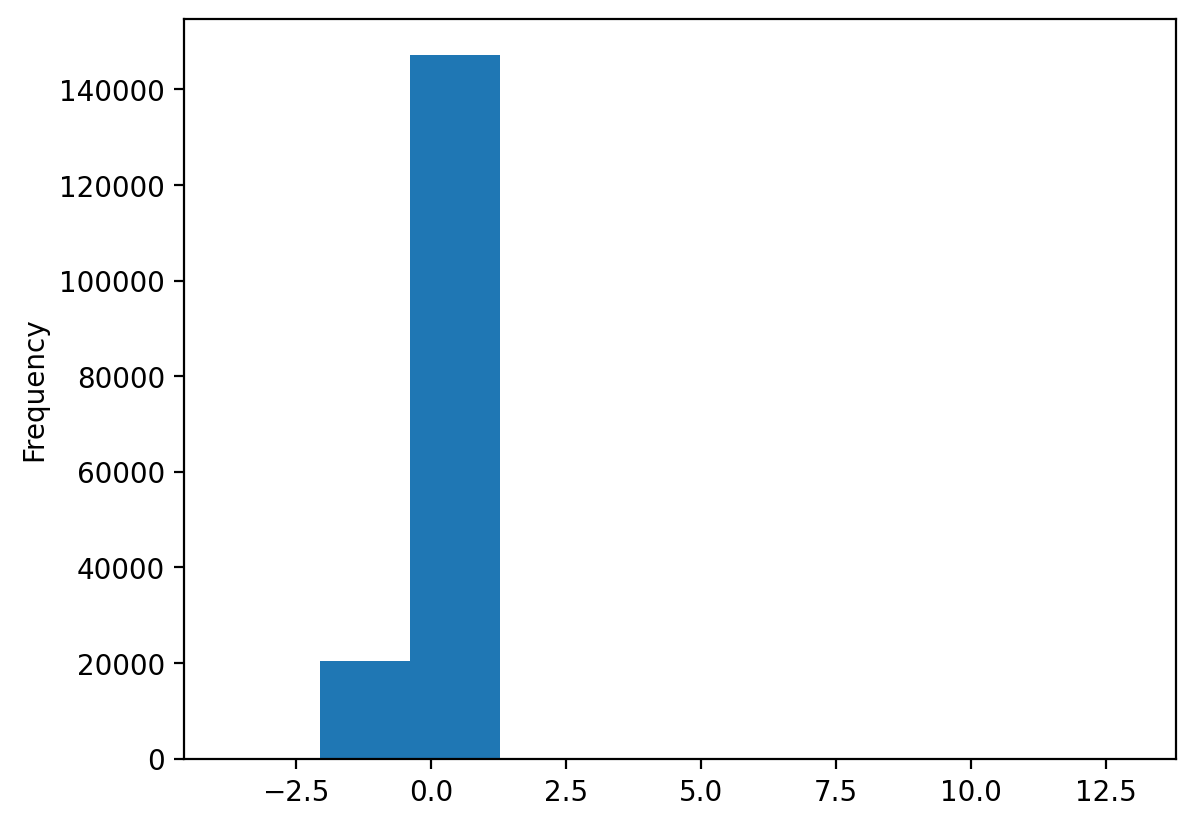

In [64]:
adata.obs.SR_score.plot.hist()

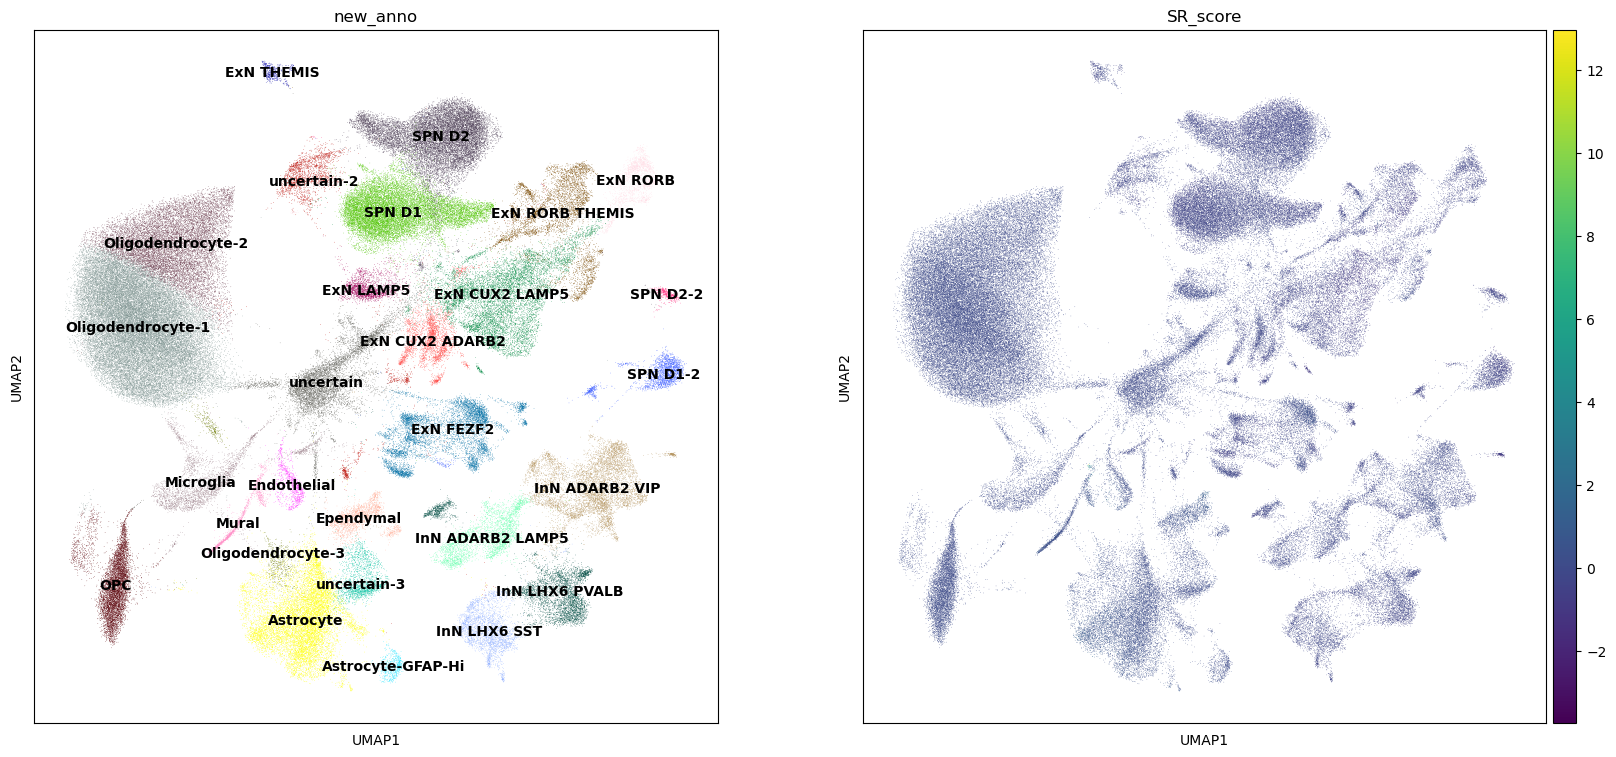

In [65]:
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    sc.pl.umap(adata, color=['new_anno', 'SR_score'], legend_loc='on data')

### score the SI, Senescence Initiators

In [74]:
type(gene_sets['SI'])

list

In [66]:
%%time
sc.tl.score_genes(adata, gene_sets['SI'], score_name='SI_score', use_raw=True)

/home/gibbsr/anaconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


CPU times: user 4.85 s, sys: 722 ms, total: 5.58 s
Wall time: 5.58 s


<AxesSubplot:ylabel='Frequency'>

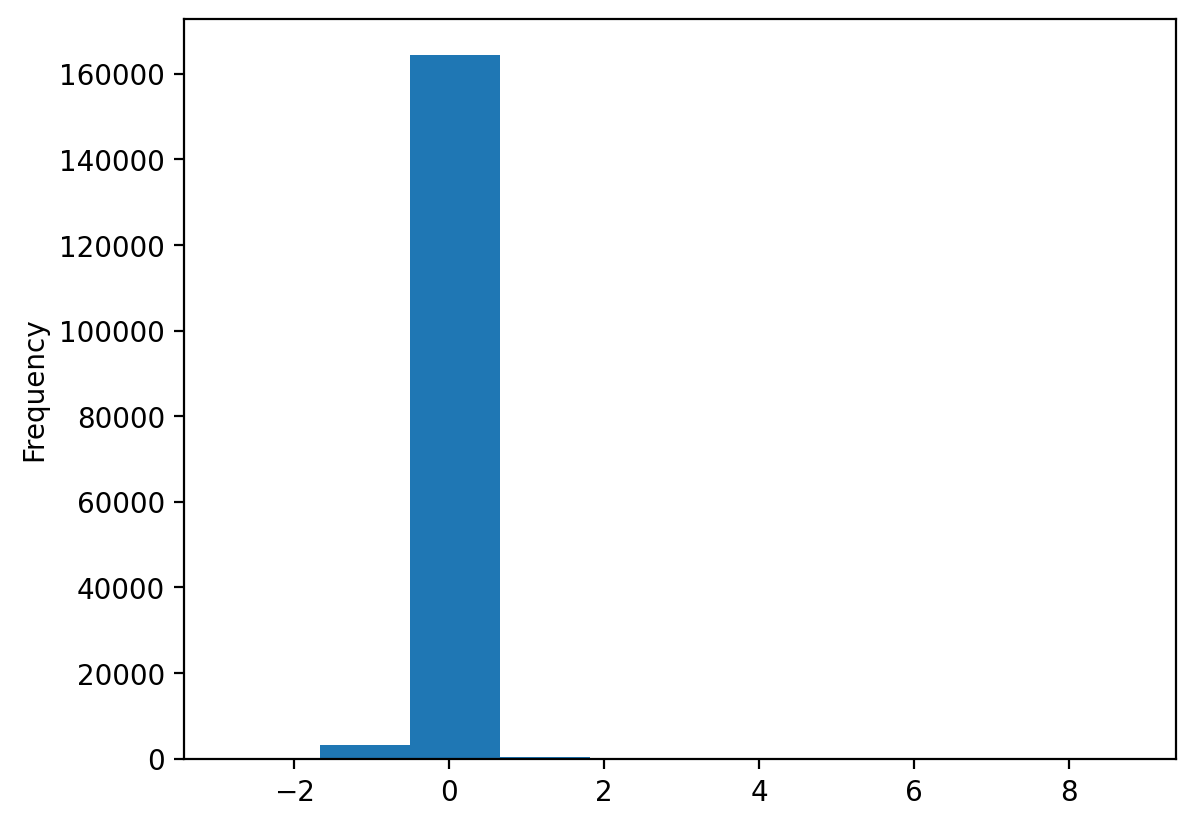

In [67]:
adata.obs.SI_score.plot.hist()

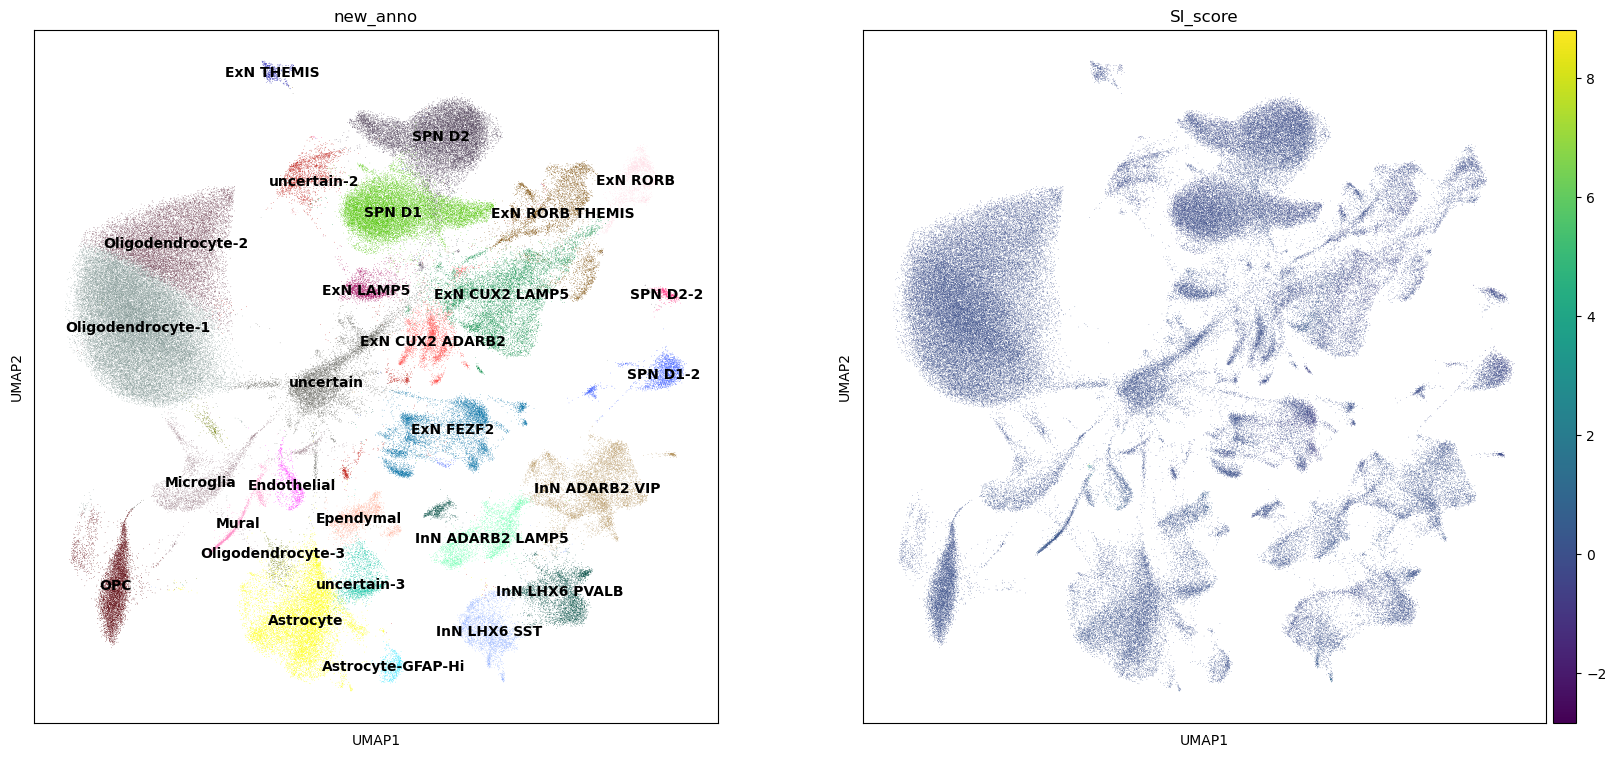

In [68]:
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    sc.pl.umap(adata, color=['new_anno', 'SI_score'], legend_loc='on data')

### score Senescence from all the senescence genes together

In [70]:
all_senes = []
for values in gene_sets.values():
    all_senes = all_senes + values
all_senes = list(set(all_senes))
print(len(all_senes))
print(all_senes)

124
['ID1', 'CDKN2D', 'CXCL1', 'IGF1', 'ICAM', 'MAP2K3', 'CSF2', 'HRAS', 'SERPINE1', 'ETS1', 'TP53', 'TIMP2', 'PRKCD', 'VIM', 'MMP3', 'CDKN1C', 'APOE', 'FGF7', 'MYC', 'MAP2K6', 'NFIA', 'NBN', 'TERF2', 'PTEN', 'VEGFA', 'SOD1', 'CCNB1', 'IGFBP5', 'RBL1', 'CDK6', 'CD44', 'NOX4', 'LPL', 'SATB1', 'TBX2', 'PIK3CA', 'PLAUR', 'CDKN2B', 'TGFB1I1', 'CCNE1', 'NFKB1', 'CD74', 'CXCL2', 'MMP1', 'MMP12', 'IRF3', 'CDKN1A', 'IL1B', 'CITED2', 'SIRT1', 'CCL8', 'IGFBP3', 'TWIST1', 'ATM', 'LMNB1', 'PCNA', 'SPARC', 'TERT', 'TBX3', 'ABL1', 'E2F3', 'AKT1', 'COL1A1', 'CST7', 'MAPK14', 'IGFBP2', 'MDM2', 'MORC3', 'FN1', 'PLAU', 'THBS1Ê(TSP-1)', 'SPP1', 'CDKN2A', 'CXCL5', 'TNF', 'CCL2', 'CSF1', 'SOD2', 'ITGAX', 'GLB1', 'CCL20', 'CCL5', 'IFNG', 'ALDH1A3', 'SERPINB2', 'IGFBP4', 'EGR1', 'GSK3B', 'TP53BP1', 'CALR', 'VEGFB', 'ING1', 'RBL2', 'CDKN1B', 'CASO8', 'E2F1', 'IRF7', 'CDC25C', 'IL11', 'IGFBP7', 'GADD45A', 'TIMP1', 'MAP2K1', 'IL1A', 'IGF1R', 'CHEK2', 'IL6', 'BMI1', 'CCNA2', 'CXCL8', 'CHEK1', 'TGFB1', 'MMP10', '

In [71]:
%%time
sc.tl.score_genes(adata, all_senes, score_name='SA_score', use_raw=True)

/home/gibbsr/anaconda3/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


CPU times: user 4.98 s, sys: 732 ms, total: 5.72 s
Wall time: 5.72 s


<AxesSubplot:ylabel='Frequency'>

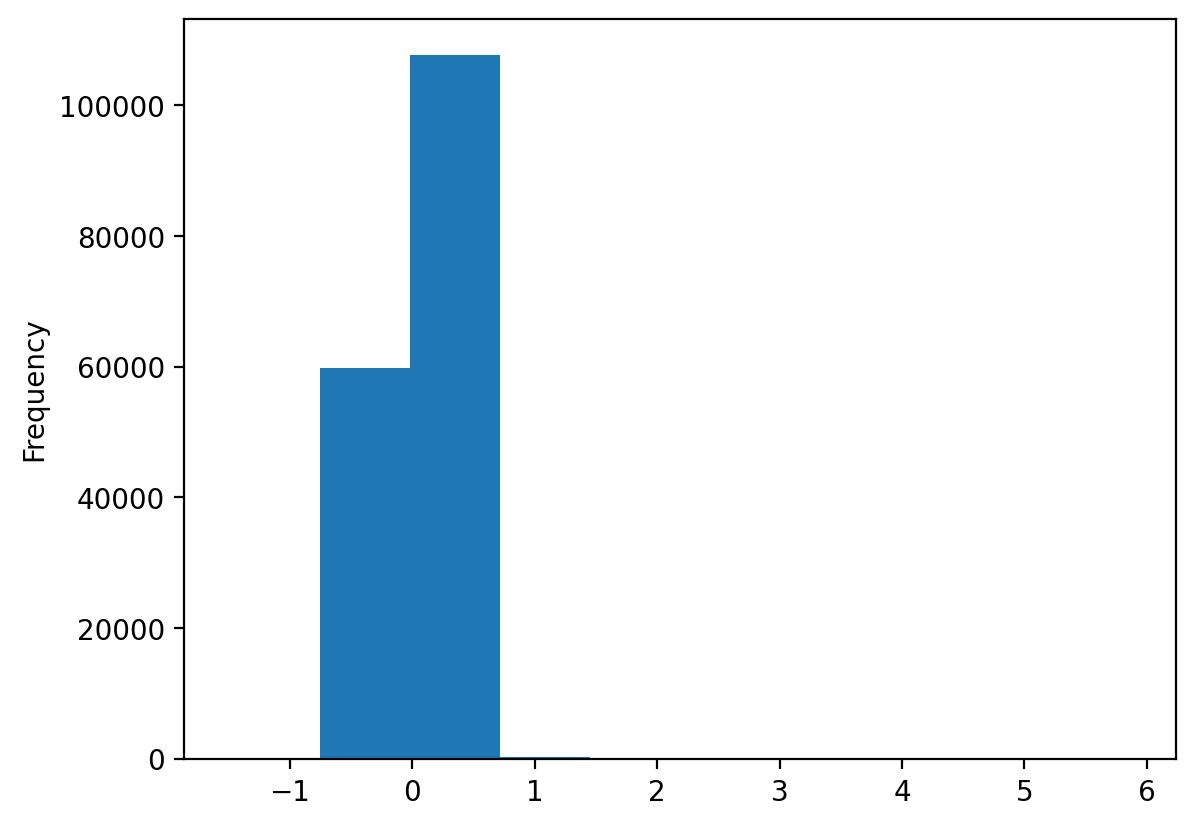

In [72]:
adata.obs.SA_score.plot.hist()

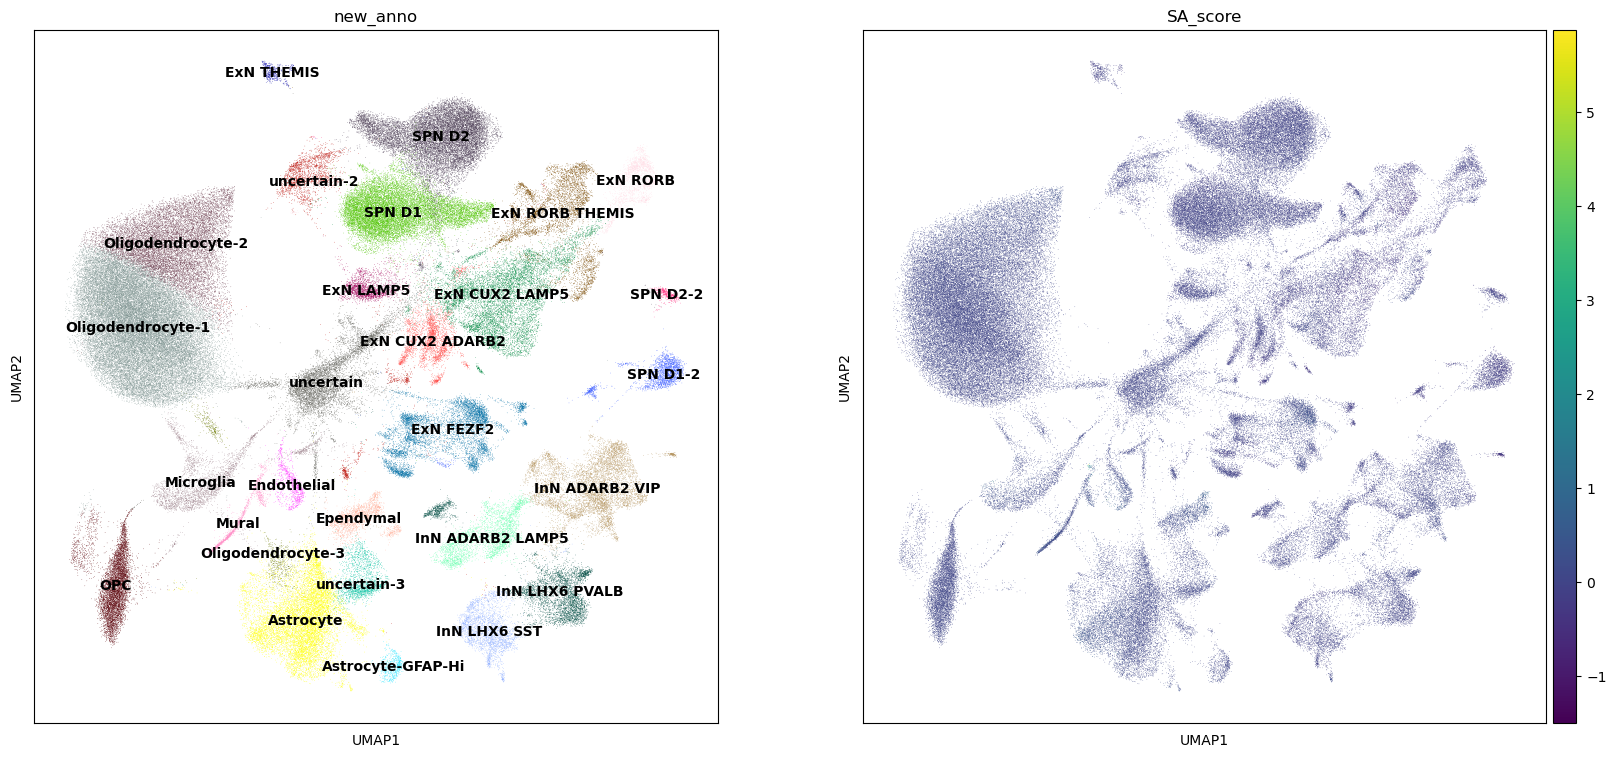

In [73]:
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    sc.pl.umap(adata, color=['new_anno', 'SA_score'], legend_loc='on data')